### Imports

In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])

import matplotlib.pyplot as plt
import numpy as np
import subjects
from subjects import stat_kw
import pandas as pd
import seaborn as sns
from neuropy import plotting
from scipy import stats
from plotters import Plotter
from stats_utils import get_bootstrap_prob, get_bootstrap_prob_paired
import ev_utils
import stats_utils
from tqdm.notebook import tqdm


grpdata = subjects.GroupData()
ev_blocks = grpdata.ev_in_chunks

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [ ]:
from stats_utils import bootstrap_resample

ev_blocks_bootstrap = bootstrap_resample(
    ev_blocks, n_iter=10000, n_jobs=10, level="session"
)

In [ ]:
fig = plotting.Fig(5, 5)

filenames = [
    "ev_bootstrap_session",
    "ev_bootstrap_pairs",
    "ev_bootstrap_session_pairs",
    "ev_bootstrap_session_mean",
    "ev_bootstrap_pairs_mean",
    "ev_bootstrap_session_pairs_mean",
]

for f, fname in enumerate(filenames):
    ax = fig.subplot(fig.gs[f])
    data = getattr(grpdata, fname)
    plotter = Plotter(
        data=data, x="zt", y="ev", hue="grp", hue_order=["NSD", "SD"], ax=ax
    )
    plotter.violinplot_sd(split=False).stat_anot_sd(
        stat_across=get_bootstrap_prob,
        stat_within=get_bootstrap_prob_paired,
        alpha_across=0.025,
        alpha_within=0.05,
    )
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_ylim(-0.02, 0.3)


ax = fig.subplot(fig.gs[2, 0])
plotter = Plotter(
    data=ev_blocks, x="zt", y="ev", hue="grp", hue_order=["NSD", "SD"], ax=ax
)
plotter.stripbarplot_sd().stat_anot_sd(
    stat_across="Kruskal", stat_within="t-test_paired"
)
ax.set_ylim(-0.02, 0.3)
# fig.savefig(subjects.figpath_sd / "ev_bootstrap_comparisons")

### (1h block) EV bootstrap

In [9]:
sessions = subjects.pf_sess()
pcorr_df = []
for sub, sess in enumerate(tqdm(sessions)):
    states = sess.brainstates
    zt_epochs = sess.get_zt_1h()
    zt_epochs = zt_epochs[["PRE", "MAZE", "0-1", "4-5", "5-6"]]
    neurons = sess.neurons_stable.get_neuron_type("pyr")

    pcorr, labels = ev_utils.get_pcorr(
        neurons=neurons, epochs=zt_epochs, ignore_epochs=sess.artifact
    )
    df = pd.DataFrame(data=pcorr, columns=labels)

    df["session"] = sub
    df["grp"] = sess.tag
    pcorr_df.append(df)

pcorr_df = pd.concat(pcorr_df, ignore_index=True)

#Sessions = 13


  0%|          | 0/13 [00:00<?, ?it/s]

In [10]:
pcorr_df

,PRE,MAZE,0-1,4-5,5-6,session,grp
0,0.120849,0.014056,0.060748,0.095090,0.105705,0,NSD
1,0.054156,-0.001929,0.015892,0.024330,0.019314,0,NSD
2,0.042926,-0.001534,0.031767,0.030015,0.011567,0,NSD
3,0.062159,0.030786,0.013622,0.013186,0.033029,0,NSD
4,0.014764,-0.002423,0.004285,-0.005575,0.008217,0,NSD
...,...,...,...,...,...,...,...
28653,0.028438,0.073548,0.085535,0.005525,0.143024,12,SD
28654,-0.027369,0.003407,-0.009833,0.043386,0.062637,12,SD
28655,0.011868,0.010320,0.063011,-0.006760,0.110205,12,SD
28656,-0.010194,0.020078,-0.004501,0.098536,0.109391,12,SD


In [11]:
from stats_utils import bootstrap_resample
from ev_utils import get_ev, get_ev_mean

kw = dict(df=pcorr_df, n_iter=10000, n_jobs=10)

boot_df = bootstrap_resample(level="both", apply=get_ev, **kw)
subjects.GroupData().save(boot_df, "ev_1h_blocks_bootstrap")

Running bootstraps for NSD group


  0%|                                                 | 0/10000 [00:00<?, ?it/s]/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outd

Running bootstraps for SD group


100%|████████████████████████████████████| 10000/10000 [00:34<00:00, 286.59it/s]


ev_1h_blocks_bootstrap saved


### EV NREM vs WAKE, NSD vs SD
- Each dataset will have separate curves, so total 6 curves

In [ ]:
from tqdm.notebook import tqdm
from neuropy.core import BinnedSpiketrain

# sessions = subjects.pf_sess()
sessions = subjects.sd.pf_sess

pcorr_df = []

for sub, sess in enumerate(tqdm(sessions)):
    post = sess.paradigm["post"].flatten()
    zt_epochs = sess.get_sliding_zt_epochs(window=900, slideby=300)
    pre = zt_epochs["PRE"].flatten()
    maze = zt_epochs["MAZE"].flatten()
    zt_epochs = zt_epochs[2:-3]  # removed PRE and MAZE

    neurons = sess.neurons_stable.get_neuron_type("pyr")
    wave_similarity = neurons.get_waveform_similarity()
    pairs_bool = wave_similarity < 0.8  # only pairs which are least similar

    get_corr = lambda epoch: (
        neurons.time_slice(epoch[0], epoch[1])
        .get_binned_spiketrains(bin_size=0.25, ignore_epochs=sess.artifact)
        .get_pairwise_corr(pairs_bool=pairs_bool)
    )

    df = pd.DataFrame()
    df["PRE"] = get_corr(pre)
    df["MAZE"] = get_corr(maze)

    for state_name in ["WK"]:
        if state_name == "WK":
            states = sess.brainstates[state_name] + sess.brainstates["AW"]
        else:
            states = sess.brainstates[state_name]

        for e in zt_epochs.itertuples():
            e_states = states.time_slice(e.start, e.stop, strict=False)
            # if sess.tag == "NSD":
            #     e_qw = qw.time_slice(e.start, e.stop, strict=False)
            # else:
            #     e_qw = sess.paradigm.from_array([e.start], [e.stop])

            if e_states.durations.sum() > 1:
                # In grosmark Buddy session sometimes there are 'zero' duration epoch, so taking care of that
                e_states = e_states.duration_slice(min_dur=0.5)
                e_spkcounts = np.hstack(
                    neurons.get_spikes_in_epochs(e_states, bin_size=0.25)[0]
                )
                e_binspk = BinnedSpiketrain(
                    e_spkcounts,
                    0.25,
                    neuron_ids=neurons.neuron_ids,
                    shank_ids=neurons.shank_ids,
                )
                e_corr = e_binspk.get_pairwise_corr(pairs_bool)
            else:
                e_corr = np.nan * np.ones(len(df))

            df[e.label] = e_corr

    df["session"] = sub
    df["grp"] = sess.tag

    pcorr_df.append(df)

pcorr_df = pd.concat(pcorr_df, ignore_index=True)

In [ ]:
from stats_utils import bootstrap_resample
from ev_utils import get_ev, get_ev_mean

kw = dict(df=pcorr_df, n_iter=1000, n_jobs=10)
ev_df = bootstrap_resample(level="both", apply=get_ev, **kw)

subjects.GroupData().save(ev_df, "ev_SD_WK_sliding_bootstrap_session_pairs")

In [ ]:
fig = subjects.SdFig().fig3

df1 = subjects.GroupData().ev_NSD_WK_sliding_bootstrap_session_pairs
df2 = subjects.GroupData().ev_SD_WK_sliding_bootstrap_session_pairs
df3 = subjects.GroupData().ev_NSD_NREM_sliding_bootstrap_session_pairs

ax = fig.subplot(fig.gs[:2, :2])
for df in [df1, df2, df3]:
    df["zt"] = df["zt"].values.astype("float")
    sns.lineplot(data=df, x="zt", y="ev")

fig.savefig(subjects.figpath_sd / "ev_sliding")

In [ ]:
# from palettable.colorbrewer.qualitative import Paired_6_r,Dark2_6,Accent_6,Pastel2_6
from palettable.cartocolors.qualitative import Bold_6, Vivid_6, Pastel_6

# Percentage sleep in the background
nrem_df = []
for sess in sessions:
    zt_epochs = sess.get_sliding_zt_epochs()[2:]
    states = sess.brainstates["QW"]
    nrem_dur = []
    for e in zt_epochs.itertuples():
        nrem_dur.append(
            states.time_slice(e.start, e.stop, strict=False).durations.sum()
        )
    nrem_dur = np.array(nrem_dur)

    nrem_df.append(
        pd.DataFrame(dict(zt=zt_epochs.labels, nrem=nrem_dur / (15 * 60), grp=sess.tag))
    )

nrem_df = pd.concat(nrem_df, ignore_index=True)
nrem_df["zt"] = nrem_df["zt"].values.astype(float)


fig = plotting.Fig(4, 2)
palette = subjects.colors_sd(1) + subjects.colors_sd(1.5)
ax = fig.subplot(fig.gs[0])
sns.lineplot(
    data=ev_df,
    x="zt",
    y="ev",
    hue="state",
    errorbar="se",
    palette=Vivid_6.mpl_colors,
    err_kws=dict(ec=None),
)
ax.set_ylabel("Explained variance")
ax.set_xlabel("Time(h)")
ax.set_title("Reactivation using pooled pairwise correlation (Hiro's data, NREM only)")
fig.legend_with_text_only(ax)

# ax2 = ax.twinx()

# for g, grp in enumerate(["NSD", "SD", "NSD_Hiro"]):
#     df = nrem_df[nrem_df.grp == grp]
#     mean_nrem = df.groupby("zt").mean(numeric_only=True)["nrem"]
#     ax2.fill_between(mean_nrem.index, 0, mean_nrem, step="mid", alpha=0.5)

# fig.toggle_spines(ax2, sides=["right"], keep=True)
# ax2.set_ylim(0, 1)
# ax2.set_xlim(0, 8)
# ax2.set_ylabel("")
# ax2.legend("", frameon=False)
fig.savefig(subjects.figpath_sd / "alldata_ev_nrem_qw")

### EV NREM vs WAKE, NSD vs SD
- Each dataset will have separate curves, so total 6 curves

In [ ]:
from tqdm.notebook import tqdm
from neuropy.core import BinnedSpiketrain

sessions = subjects.pf_sess()

# sessions = subjects.NsdGrosmark().ratBuddy_06272013

pcorr_df = []

for sub, sess in enumerate(tqdm(sessions)):
    post = sess.paradigm["post"].flatten()
    zt_epochs = sess.get_sliding_zt_epochs(window=900, slideby=300)
    pre = zt_epochs["PRE"].flatten()
    maze = zt_epochs["MAZE"].flatten()
    zt_epochs = zt_epochs[2:]  # removed PRE and MAZE

    neurons = sess.neurons_stable.get_neuron_type("pyr")
    wave_similarity = neurons.get_waveform_similarity()
    pairs_bool = wave_similarity < 0.8  # only pairs which are least similar

    get_corr = lambda epoch: (
        neurons.time_slice(epoch[0], epoch[1])
        .get_binned_spiketrains(bin_size=0.25, ignore_epochs=sess.artifact)
        .get_pairwise_corr(pairs_bool=pairs_bool)
    )

    df = pd.DataFrame()
    df["PRE"] = get_corr(pre)
    df["MAZE"] = get_corr(maze)

    for state_name in ["QW"]:
        if state_name == "QW":
            states = sess.brainstates[state_name] + sess.brainstates["AW"]
        else:
            states = sess.brainstates[state_name]

        for e in zt_epochs.itertuples():
            e_states = states.time_slice(e.start, e.stop, strict=False)
            # if sess.tag == "NSD":
            #     e_qw = qw.time_slice(e.start, e.stop, strict=False)
            # else:
            #     e_qw = sess.paradigm.from_array([e.start], [e.stop])

            if e_states.durations.sum() > 1:
                # In grosmark Buddy session sometimes there are 'zero' duration epoch, so taking care of that
                e_states = e_states.duration_slice(min_dur=0.5)
                e_spkcounts = np.hstack(
                    neurons.get_spikes_in_epochs(e_states, bin_size=0.25)[0]
                )
                e_binspk = BinnedSpiketrain(
                    e_spkcounts,
                    0.25,
                    neuron_ids=neurons.neuron_ids,
                    shank_ids=neurons.shank_ids,
                )
                e_corr = e_binspk.get_pairwise_corr(pairs_bool)
            else:
                e_corr = np.nan * np.ones(len(df))

            df[e.label] = e_corr

    df["session"] = sub
    df["grp"] = sess.tag

    pcorr_df.append(df)

pcorr_df = pd.concat(pcorr_df, ignore_index=True)

In [ ]:
from ev_funcs import sd_delta_ev
import pingouin as pg

ev_df = []

n_sessions = len(sessions)
for dataset in ["BG", "HM", "GM"]:
    df_dataset = pcorr_df[pcorr_df.dataset == dataset]
    session_id = np.unique(df_dataset.session.values)

    for i in tqdm(session_id):
        df = df_dataset[df_dataset["session"] != i]  # one session left out
        df = df.dropna(axis=1, how="all")

        columns = df.columns
        epochs = columns[~df.columns.isin(["PRE", "MAZE", "grp", "session", "dataset"])]

        try:
            ev = np.zeros(len(epochs))
            for e, epoch in enumerate(epochs):
                r = pg.partial_corr(data=df, x="MAZE", y=epoch, covar="PRE").r.values
                ev[e] = r**2
        except:
            ev = np.nan * np.zeros(len(epochs))

        new_labels = [f"{dataset}-{_}" for _ in epochs]
        ev_df.append(pd.DataFrame(dict(ev=ev, zt=new_labels)))
        # ev_df.append(pd.DataFrame(dict(ev=sd_ev, zt=zt_epochs.labels[2:], method="SD")))

ev_df = pd.concat(ev_df, ignore_index=True)
# separating zt names to float and adding a column for states
ev_df["state"] = [_.split("_")[0] for _ in ev_df["zt"]]  # separate dataset/state name
ev_df["zt"] = [float(_.split("_")[1]) for _ in ev_df["zt"]]  # string to float

In [ ]:
# from palettable.colorbrewer.qualitative import Paired_6_r,Dark2_6,Accent_6,Pastel2_6
from palettable.cartocolors.qualitative import Bold_6, Vivid_6, Pastel_6

# Percentage sleep in the background
nrem_df = []
for sess in sessions:
    zt_epochs = sess.get_sliding_zt_epochs()[2:]
    states = sess.brainstates["QW"]
    nrem_dur = []
    for e in zt_epochs.itertuples():
        nrem_dur.append(
            states.time_slice(e.start, e.stop, strict=False).durations.sum()
        )
    nrem_dur = np.array(nrem_dur)

    nrem_df.append(
        pd.DataFrame(dict(zt=zt_epochs.labels, nrem=nrem_dur / (15 * 60), grp=sess.tag))
    )

nrem_df = pd.concat(nrem_df, ignore_index=True)
nrem_df["zt"] = nrem_df["zt"].values.astype(float)


fig = plotting.Fig(4, 2)
palette = subjects.colors_sd(1) + subjects.colors_sd(1.5)
ax = fig.subplot(fig.gs[0])
sns.lineplot(
    data=ev_df,
    x="zt",
    y="ev",
    hue="state",
    errorbar="se",
    palette=Vivid_6.mpl_colors,
    err_kws=dict(ec=None),
)
ax.set_ylabel("Explained variance")
ax.set_xlabel("Time(h)")
ax.set_title("Reactivation using pooled pairwise correlation (Hiro's data, NREM only)")
fig.legend_with_text_only(ax)

# ax2 = ax.twinx()

# for g, grp in enumerate(["NSD", "SD", "NSD_Hiro"]):
#     df = nrem_df[nrem_df.grp == grp]
#     mean_nrem = df.groupby("zt").mean(numeric_only=True)["nrem"]
#     ax2.fill_between(mean_nrem.index, 0, mean_nrem, step="mid", alpha=0.5)

# fig.toggle_spines(ax2, sides=["right"], keep=True)
# ax2.set_ylim(0, 1)
# ax2.set_xlim(0, 8)
# ax2.set_ylabel("")
# ax2.legend("", frameon=False)
fig.savefig(subjects.figpath_sd / "alldata_ev_nrem_qw")

### EV in NREM in POST

In [ ]:
pcorr_df = subjects.GroupData().pairwise_correlations_NREM
kw = dict(df=pcorr_df, n_iter=10000, n_jobs=6)

# ------ EV using pooled correlation --------
ev_df1 = stats_utils.bootstrap_resample(level="both", apply=ev_utils.get_ev, **kw)
subjects.GroupData().save(ev_df1, "ev_NREM_bootstrap")

In [ ]:
_, ax = plt.subplots()

ev_df["zt"] = ev_df["zt"] * (5 / 60)
sns.lineplot(data=ev_df, x="zt", y="ev", hue="grp")

### EV aligned by onset of NREM dense periods

In [ ]:
pcorr_df = subjects.GroupData().pairwise_correlations_aligned_by_NREM_onset
kw = dict(df=pcorr_df, n_iter=10000, n_jobs=6)

# ------ EV using pooled correlation --------
ev_df1 = stats_utils.bootstrap_resample(level="both", apply=ev_utils.get_ev, **kw)
subjects.GroupData().save(ev_df1, "ev_aligned_by_NREM_onset")

# # ------ EV mean --------
# ev_df2 = stats_utils.bootstrap_resample(level="both", apply=ev_utils.get_ev_mean, **kw)
# subjects.GroupData().save(ev_df2, "ev_mean_aligned_by_NREM_onset")

In [ ]:
_, ax = plt.subplots()

ev_df["zt"] = ev_df["zt"] * (5 / 60)
sns.lineplot(data=ev_df, x="zt", y="ev", hue="grp")

### EV in WAKE sliding epochs

In [ ]:
pcorr_df = subjects.GroupData().pairwise_correlations_aligned_by_WAKE

kw = dict(df=pcorr_df, n_iter=10000, n_jobs=6)

# # ------- EV using pooled pairwise correlations-----
ev_df1 = stats_utils.bootstrap_resample(level="both", apply=ev_utils.get_ev, **kw)
subjects.GroupData().save(ev_df1, "ev_aligned_by_WAKE")

# # ----EV mean across sessions ---------
# ev_df2 = stats_utils.bootstrap_resample(level="both", apply=ev_utils.get_ev_mean, **kw)
# subjects.GroupData().save(ev_df2, "ev_mean_aligned_by_WAKE")

In [ ]:
_, ax = plt.subplots()

ev_df["zt"] = ev_df["zt"] * (5 / 60)
sns.lineplot(data=ev_df, x="zt", y="ev", hue="grp")

### Test decay constants

In [ ]:
from scipy.optimize import curve_fit

nrem_duration_df = subjects.GroupData().nrem_duration_NREM
mean_duration = (
    nrem_duration_df.groupby(["grp", "zt"]).mean(numeric_only=True).reset_index()
)
mean_duration["zt"] = mean_duration["zt"].astype("float") * (5 / 60)
mean_duration["duration"] = mean_duration["duration"] / (900)


# nrem_df = subjects.GroupData().pairwise_correlations_NREM
nrem_df = subjects.GroupData().pairwise_correlations_WAKE
nrem_kw = dict(df=nrem_df, n_iter=1, n_jobs=6)
nrem_ev_df = stats_utils.bootstrap_resample(
    level="both", apply=ev_utils.get_ev, **nrem_kw
)

In [ ]:
# _, axs = plt.subplots(1, 2)
fig = subjects.SdFig().fig_supp(8, 5)

for g, grp in enumerate(["NSD", "SD"]):
    ev_df = nrem_ev_df[nrem_ev_df.grp == grp]
    time = ev_df["zt"].values.astype("float")
    ev = ev_df["ev"].values.astype("float")

    sort_indx = np.argsort(time)
    time = np.round(time[sort_indx] * (5 / 60), 2)
    ev = ev[sort_indx]

    # grp_nrem_dur_df = mean_duration[mean_duration.grp == grp]
    # nrem_t = np.round(grp_nrem_dur_df["zt"].values.astype(float), 2)
    # nrem_dur = grp_nrem_dur_df["duration"].values

    # good_indx = np.isin(time, nrem_t[nrem_dur >= 0.5])

    # time = time[good_indx]
    # ev = ev[good_indx]

    linfit = stats.linregress(time, ev)
    m = linfit.slope
    c = linfit.intercept
    yfit = m * time + c
    # half_max_indx = np.where(yfit < (ev.max() / 2))[0]
    half_max = ev.max() / 2
    half_max_time = (half_max - c) / m

    popt, _ = curve_fit(ev_utils.exp_fit, time, ev)

    # ax = axs[g]
    ax = fig.subplot(fig.gs[g])

    ax.plot(time, ev, color="gray")
    ax.plot(time, yfit, "r")
    ax.plot(time, ev_utils.exp_fit(time, *popt), "g")
    ax.axvline(half_max_time, color="k", ls="--", lw=1)
    # ax.axline(half_max_time, color="k", ls="--", lw=1)
    ax.axhline(half_max, color="k", ls="--", lw=1)
    ax.set_xlabel("ZT time (h)")

fig.savefig(subjects.figpath_sd / "timeconstant_examples", format="svg")

### EV slopes for NREM and WAKE

In [ ]:
# # ------ high NREM slopes --------
nrem_pcorr_df = ev_utils.get_high_NREM_pcorr_df()

nrem_kw = dict(df=nrem_pcorr_df, n_iter=10000, n_jobs=6)
nrem_tc_df = stats_utils.bootstrap_resample(
    level="both", apply=ev_utils.get_slope, **nrem_kw
)
subjects.GroupData().save(nrem_tc_df, "ev_slopes_high_NREM_bootstrap")

# ----- WAKE slopes ------
wake_df = subjects.GroupData().pairwise_correlations_WAKE
wake_kw = dict(df=wake_df, n_iter=10000, n_jobs=6)
wake_tc_df = stats_utils.bootstrap_resample(
    level="both", apply=ev_utils.get_slope, **wake_kw
)
subjects.GroupData().save(wake_tc_df, "ev_slopes_WAKE_bootstrap")

### EV time constants for NREM and WAKE aligned

In [35]:
# ------ NREM time constants --------
# nrem_df = subjects.GroupData().pairwise_correlations_NREM
# nrem_kw = dict(df=nrem_df[nrem_df.grp == "NSD"], n_iter=100, n_jobs=6)
# nrem_tc_df = stats_utils.bootstrap_resample(
#     level="both", apply=ev_utils.get_linear_time_constant, **nrem_kw
# )
# subjects.GroupData().save(nrem_tc_df, "ev_linear_tc_high_NREM")

# ------ high NREM time constants --------
# nrem_pcorr_df = ev_utils.get_high_NREM_pcorr_df()

# nrem_kw = dict(df=nrem_pcorr_df, n_iter=10000, n_jobs=6)
# nrem_tc_df = stats_utils.bootstrap_resample(
#     level="both", apply=ev_utils.get_linear_time_constant_ev_rev, **nrem_kw
# )

# subjects.GroupData().save(nrem_tc_df, "ev_linear_tc_high_NREM")

# ----- WAKE time constants ------
# wake_df = subjects.GroupData().pairwise_correlations_WAKE
# wake_kw = dict(df=wake_df, n_iter=10, n_jobs=6)
# wake_tc_df = stats_utils.bootstrap_resample(
#     level="both", apply=ev_utils.get_linear_time_constant_ev_rev, **wake_kw
# )
# subjects.GroupData().save(wake_tc_df, "ev_linear_tc_WAKE")


# # # ------ NREM aligned time constants --------
# nrem_df = subjects.GroupData().pairwise_correlations_aligned_by_NREM_onset
# nrem_kw = dict(df=nrem_df[nrem_df.grp == "NSD"], n_iter=100, n_jobs=6)
# nrem_tc_df = stats_utils.bootstrap_resample(
#     level="both", apply=ev_utils.get_ev_time_constant, **nrem_kw
# )
# subjects.GroupData().save(nrem_tc_df, "ev_tc_aligned_by_NREM_onset")

# # # ------ Wake time constants --------
# wake_df = subjects.GroupData().pairwise_correlations_WAKE
# wake_kw = dict(df=wake_df, n_iter=100, n_jobs=6)
# wake_tc_df = stats_utils.bootstrap_resample(
#     level="both", apply=ev_utils.get_ev_time_constant, **wake_kw
# )
# subjects.GroupData().save(wake_tc_df, "ev_tc_aligned_by_WAKE")

# # # ------ NREM aligned time constants - exponential --------
# nrem_df = subjects.GroupData().pairwise_correlations_aligned_by_NREM_onset
# nrem_kw = dict(df=nrem_df[nrem_df.grp == "NSD"], n_iter=10000, n_jobs=6)
# nrem_tc_df = stats_utils.bootstrap_resample(
#     level="both", apply=ev_utils.get_exp_time_constant, **nrem_kw
# )
# subjects.GroupData().save(nrem_tc_df, "ev_tc_aligned_by_NREM_onset_NRK")

# # # ------ Wake time constants - exponential --------
# wake_df = subjects.GroupData().pairwise_correlations_WAKE
# wake_kw = dict(df=wake_df, n_iter=10000, n_jobs=6)
# wake_tc_df = stats_utils.bootstrap_resample(
#     level="both", apply=ev_utils.get_exp_time_constant, **wake_kw
# )
# subjects.GroupData().save(wake_tc_df, "ev_tc_aligned_by_WAKE_NRK")

Running bootstraps for NSD group


100%|█████████████████████████████████████| 10000/10000 [12:05<00:00, 13.78it/s]


Running bootstraps for SD group


100%|█████████████████████████████████████| 10000/10000 [09:26<00:00, 17.65it/s]


ev_tc_aligned_by_WAKE_NRK saved


In [33]:
tcs = nrem_tc_df.tc * 5/60 * np.log(2)
tcs.max()

10.165416017641087

In [17]:
wake_df.groupby(["grp", "session"]).apply(ev_utils.get_exp_time_constant).reset_index()

,grp,session,level_2,tc
0,NSD,0,0,2.496535e+01
1,NSD,1,0,2.149971e+01
2,NSD,2,0,2.308059e+01
3,NSD,3,0,1.069088e+01
4,NSD,4,0,4.453088e+01
5,NSD,5,0,5.335441e+01
6,SD,6,0,7.952633e+00
7,SD,7,0,8.510687e+01
8,SD,8,0,2.532066e+01
9,SD,9,0,1.405616e+00


In [21]:
ev_df_split = wake_df.groupby(["grp", "session"]).apply(ev_utils.get_ev_rev)

<Axes: xlabel='zt', ylabel='ev'>

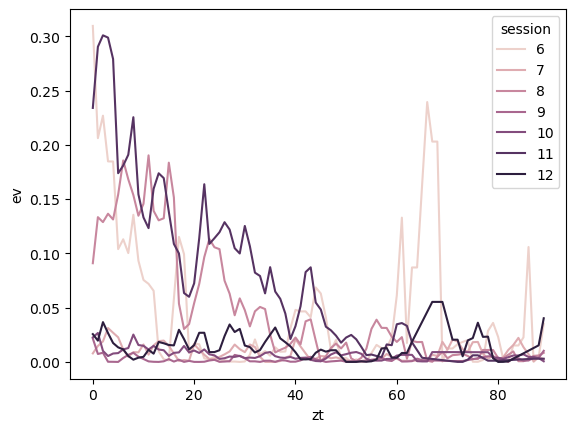

In [28]:
# Why is session 12 giving such a crazy high value?
ev_df_split = ev_df_split.reset_index()
_, ax = plt.subplots()
sns.lineplot(data=ev_df_split[ev_df_split.grp == "SD"], x="zt", y="ev", hue="session")


In [ ]:
df1 = subjects.GroupData().ev_linear_tc_high_NREM
df1["grp"] = "NSD-NREM"
df1["tc"] = df1["tc"] * (5 / 60)

df2 = subjects.GroupData().ev_linear_tc_WAKE
df2["tc"] = df2["tc"] * (5 / 60)
df = pd.concat([df1, df2], ignore_index=True)

x = df[df.grp == "NSD-NREM"].tc.values
y = df[df.grp == "SD"].tc.values
print(get_bootstrap_prob(x, y))

fig = subjects.SdFig().fig_supp()
ax = fig.subplot(fig.gs[0])
# sns.boxplot(data=df, x="grp", y="goodness_fit", hue="fit", showfliers=False)
sns.boxplot(data=df, x="grp", y="tc", showfliers=False, ax=ax, linewidth=0.4, width=0.4)
# ax.set_ylim(-4, 6)
# fig.savefig(subjects.figpath_sd / "time_constants_high_NREM", format="svg")

### Comparing Goodness of fit for exponential and linear decay

In [ ]:
# ------ NREM time constants --------
# nrem_df = subjects.GroupData().pairwise_correlations_NREM
nrem_df = ev_utils.get_high_NREM_pcorr_df()
nrem_kw = dict(df=nrem_df[nrem_df.grp == "NSD"], n_iter=1000, n_jobs=6)
nrem_tc_df = stats_utils.bootstrap_resample(
    level="both", apply=ev_utils.get_decay_goodness_of_fit, **nrem_kw
)
subjects.GroupData().save(nrem_tc_df, "ev_goodness_fit_NREM")

# ----- WAKE time constants ------
# wake_df = subjects.GroupData().pairwise_correlations_WAKE
# wake_kw = dict(df=wake_df, n_iter=1000, n_jobs=6)
# wake_tc_df = stats_utils.bootstrap_resample(
#     level="both", apply=ev_utils.get_decay_goodness_of_fit, **wake_kw
# )
# subjects.GroupData().save(wake_tc_df, "ev_goodness_fit_WAKE")

In [ ]:
df1 = subjects.GroupData().ev_goodness_fit_NREM
df1["grp"] = "NSD-NREM"
df2 = subjects.GroupData().ev_goodness_fit_WAKE
df = pd.concat([df1, df2], ignore_index=True)


fig = subjects.SdFig().fig_supp()
ax = fig.subplot(fig.gs[0])
sns.boxplot(
    data=df,
    x="grp",
    y="goodness_fit",
    hue="fit",
    showfliers=False,
    ax=ax,
    linewidth=0.4,
)
ax.set_xlabel("")
ax.set_ylabel("Goodness of fit")
ax.legend("", frameon=False)
# fig.savefig(subjects.figpath_sd / "ev_goodness_of_fit", format="svg")

In [ ]:
x = df[df.grp == "NSD-NREM"].tc.values
y = df[df.grp == "SD"].tc.values

get_bootstrap_prob(x, y)